In [1]:
import torch
import os, sys
import numpy as np
parent_dir = os.path.abspath('../')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
from dct.dct_lee import DCT, IDCT
os.environ['CUDA_VISIBLE_DEVICES']='3'

In [ ]:
a = torch.tensor([[[1.,2.,3.,4.,5.,6.,7.,8.],
                  [2.,5.,6.,3.,4.,5.,8.,5.],
                  [8.,9.,6.,7.,3.,4.,5.,6.]]]).cuda()
dct = DCT().cuda()
idct = IDCT().cuda()
b = dct(a)
ab = idct(b)
print(b)
print(ab)

In [ ]:
import numpy as np
from scipy.fft import dct as sci_dct
from scipy.fft import idct as sci_idct
aa = np.array([1.,2.,3.,4.,5.,6.,7.,8.])
bb = sci_dct(aa, norm='ortho')
aabb = sci_idct(bb, norm='ortho')
print(bb)
print(aabb)
# match with matlab

In [ ]:
import torch
from dct.discrete_spectral_transform import dct_N
a = torch.tensor([[1.,2.,3.,4.,5.,6.,7.,8.],
                  [2.,5.,6.,3.,4.,5.,8.,5.],
                  [8.,9.,6.,7.,3.,4.,5.,6.]]).cuda()
print(a.size())

In [ ]:
b = dct(a)
print(b)

In [ ]:
import torch
a = torch.tensor([[1.,2.,3.,4.,5.,6.,7.,8.],
                  [2.,5.,6.,3.,4.,5.,8.,5.],
                  [8.,9.,6.,7.,3.,4.,5.,6.]])
b = torch.tensor([1.,1.,4.,5.,1.,4.,1.,9.])
print(torch.mul(a,b))

In [ ]:
a = torch.rand((5,3840))#16bins, 256hop
b = torch.stft(a,1024,256,1024,None,True)
c = torch.stft(a,1024,256,1024,None,False)
print(b.size())
print(c.size())

tensor(-2.3373e-05)


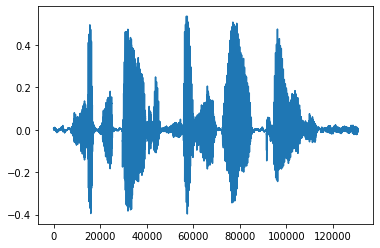

In [3]:
import torchaudio
import matplotlib.pyplot as plt
import torch
import torchaudio.functional as aF
audio_path = '/root/VCTK-Corpus/wav48/p227/p227_003.wav'
audio, fs = torchaudio.load(audio_path)
K = 50000
audio_seg = audio[...,K:130816+K].squeeze()
print(audio_seg.mean())
plt.plot(audio_seg)
plt.show()

torch.Size([512, 512])
cuda:0


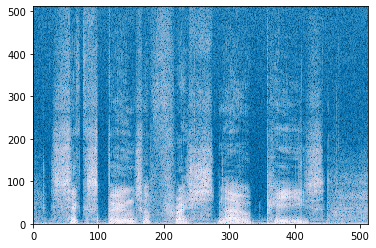

In [4]:
from models.mdct import MDCT2, IMDCT2
mdct2 = MDCT2(n_fft=512, hop_length=256, win_length=512, window=kbdwin, center=True)
spectro_2 = mdct2(audio_seg.cuda().squeeze(0)).permute(1,0)
spectro2 = aF.amplitude_to_DB((spectro_2.abs() + 1e-7),20,1e-7,1).squeeze(0)
print(spectro2.size())
print(spectro2.device)
sp_fig, sp_ax = plt.subplots()
sp_ax.pcolormesh(spectro2.cpu().numpy(), cmap='PuBu_r')
plt.show()

In [7]:
pha = torch.sign(spectro_2)
pha_ = torch.sign(torch.abs(spectro_2+1e-7)-torch.abs(spectro_2-1e-7))
print(1,torch.all(pha==pha_))
p1 = aF.amplitude_to_DB(torch.abs(spectro_2+1e-7),20,1e-7,1)
p1 = aF.DB_to_amplitude(p1,10,0.5)
p2 = aF.amplitude_to_DB(torch.abs(spectro_2-1e-7),20,1e-7,1)
p2 = aF.DB_to_amplitude(p2,10,0.5)
pha_ = torch.sign(p1-p2)
print(2,torch.all(pha==pha_))

1 tensor(True, device='cuda:0')
2 tensor(True, device='cuda:0')


torch.Size([130816])
tensor(-2.3373e-05, device='cuda:0', dtype=torch.float64)


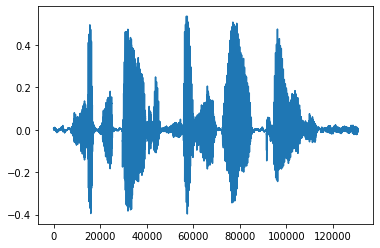

In [101]:
imdct2 = IMDCT2(n_fft=512, hop_length=256, win_length=512, window=kbdwin, center=True)
recover2 = imdct2(spectro_2.permute(1,0).unsqueeze(0).contiguous()).squeeze()
print(recover2.size())
print(recover2.mean())
plt.plot(recover2.cpu().numpy())
plt.show()

1.0114327172459405e-33


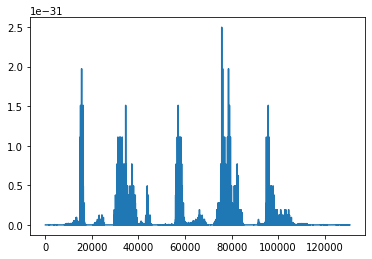

In [102]:
err2 = torch.pow(recover2.cpu()-audio_seg.cpu(),2).squeeze().numpy()
print(err2.mean())
plt.plot(err2)
plt.show()

In [83]:
# Matlab style MDCT
from torch import nn
from torch.nn.functional import pad
class MDCT(nn.Module):
    def __init__(self, n_fft=2048, hop_length=None, win_length=None, window=None, center=True, pad_mode='constant', device='cuda') -> None:
        super().__init__()
        self.n_fft = n_fft
        self.pad_mode = pad_mode
        self.device = device
        self.hop_length = hop_length
        self.center = center

        # making window
        if window is None:
            window = torch.ones
        if callable(window):
            self.win_length = int(win_length)
            self.window = window(self.win_length).to(self.device)
        else:
            self.window = window.to(self.device)
            self.win_length = len(window)

        assert self.win_length <= self.n_fft, 'Window lenth %d should be no more than fft length %d'%(self.win_length, self.n_fft)
        assert self.hop_length <= self.win_length, 'You hopped more than one frame'

        self.exp1 = torch.exp(-1j*torch.pi/self.n_fft*torch.arange(start=0, end=self.n_fft,step=1, dtype=torch.float64)).to(self.device)
        self.exp2 = torch.exp(-1j*(torch.pi/(2*self.n_fft)+torch.pi/4)*torch.arange(start=1, end=self.n_fft, step=2, dtype=torch.float64)).to(self.device)

    def forward(self, signal):
        test = {}
        test['signal'] = signal.cpu().numpy()
        # Pad the signal to a proper length
        signal_len = int(len(signal))
        start_pad = 0
        # Pad the signal so that the t-th frame is centered at time t * hop_length. Otherwise, the t-th frame begins at time t * hop_length.
        if self.center:
            start_pad = self.hop_length
        additional_len = signal_len%self.hop_length
        end_pad = start_pad
        if additional_len:
            end_pad = start_pad + self.hop_length - additional_len
        signal = pad(signal, (start_pad,end_pad), mode=self.pad_mode)
        test['pad'] = signal.cpu().numpy()

        # Slice the signal with overlapping
        signal = signal.unfold(dimension=-1, size=self.win_length, step=self.hop_length)
        test['unfold'] = signal.cpu().numpy()

        # Apply windows to each pieces
        signal = torch.mul(signal.to(self.device), self.window.to(self.device))
        test['window'] = signal.cpu().numpy()

        # Pad zeros for DCT
        if self.n_fft > self.win_length:
            signal = pad(signal, (0, self.n_fft-self.win_length), mode='constant')
        signal = signal*self.exp1
        test['S_exp1'] = signal.cpu().numpy()
        print(signal.size())
        signal = torch.fft.fft(signal)[...,:self.n_fft//2]
        test['S_fft'] = signal.cpu().numpy()
        signal = self.exp2*signal
        test['S_exp2'] = signal.cpu().numpy()
        return torch.real(signal),test

torch.Size([257, 1024])
torch.Size([512, 257])
cuda:0


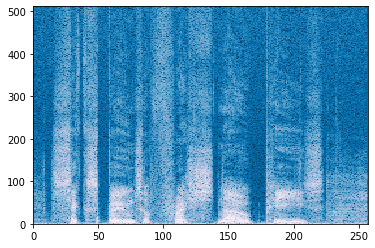

In [99]:
mdct1 = MDCT(n_fft=1024, hop_length=512, win_length=1024, window=kbdwin, center=True)
spectro_1,test = mdct1(audio_seg.cuda().squeeze(0))
spectro1 = aF.amplitude_to_DB((spectro_1.permute(1,0).abs() + 1e-4),20,1e-4,1).squeeze(0)
print(spectro1.size())
print(spectro1.device)
sp_fig, sp_ax = plt.subplots()
sp_ax.pcolormesh(spectro1.cpu().numpy(), cmap='PuBu_r')
plt.show()

In [69]:
N = 1024
exp1 = torch.exp(-1j*torch.pi/N*torch.arange(start=0, end=N,step=1, dtype=torch.float64))
exp2 = torch.exp(-1j*(torch.pi/(2*N)+torch.pi/4)*torch.arange(start=1, end=N, step=2, dtype=torch.float64))
fft_test = torch.fft.fft(exp1)
#fft_test = torch.fft.fftshift(fft_test,dim=-1)
from scipy.io import savemat
mdic = {"e1":exp1.cpu().numpy(),"e2":exp2.cpu().numpy(),"fft_test":fft_test.cpu().numpy()}
savemat("exp.mat", mdic)
savemat("test.mat", test)

In [85]:
from torch.nn.functional import fold
class IMDCT(nn.Module):
    def __init__(self, n_fft=2048, hop_length=1024, win_length=None, window=None, center=True, pad_mode='constant', out_length=None,device='cuda') -> None:
        super().__init__()
        self.n_fft = n_fft
        self.pad_mode = pad_mode
        self.device = device
        self.hop_length = hop_length
        self.center = center
        self.out_length = out_length

        # making window
        if window is None:
            window = torch.ones
        if callable(window):
            self.win_length = int(win_length)
            self.window = window(self.win_length).to(self.device)
        else:
            self.window = window.to(self.device)
            self.win_length = len(window)

        assert self.win_length <= self.n_fft, 'Window lenth %d should be no more than fft length %d'%(self.win_length, self.n_fft)
        assert self.hop_length <= self.win_length, 'You hopped more than one frame'

        self.exp1 = torch.exp(-1j*(torch.pi/(2*self.n_fft)+torch.pi/4)*torch.arange(start=1, end=self.n_fft, step=2, dtype=torch.float64)).to(self.device)
        self.exp2 = torch.exp(-1j*torch.pi*torch.arange(start=0, end=2*self.n_fft,step=2, dtype=torch.float64)/(2*self.n_fft)).to(self.device)


    def forward(self, signal):
        assert signal.dim() == 3, 'Only tensors shaped in BHW are supported, got tensor of shape %s'%(str(signal.size()))
        assert 2*signal.size()[-1] == self.n_fft, 'The last dim of input tensor should match the half of n_fft. Expected %d ,got %d'%(self.n_fft//2, signal.size()[-1])

        # Inverse transform at the last dim
        print(signal.size())
        signal = self.exp1*signal
        print(signal.size())
        signal = torch.fft.fft(signal,n=self.n_fft)
        print(signal.size())
        signal = torch.real(signal*self.exp2)

        # Remove padded zeros when doing dct
        if self.n_fft > self.win_length:
            signal = signal[...,:self.win_length]

        # Apply windows to each pieces
        signal = torch.mul(signal, self.window)

        # Overlap-adding by fold()
        out_len = (signal.size()[-2]-1) * self.hop_length + self.win_length
        signal = fold(signal.transpose_(-1,-2), kernel_size=(1,self.win_length), stride=(1,self.hop_length), output_size=(1,out_len)) * (4/self.n_fft)

        if self.center:
            # extract the middle part
            signal = signal[..., self.hop_length:-self.hop_length]

        return signal if self.out_length is None else signal[...,:self.out_length]

torch.Size([1, 257, 512])
torch.Size([1, 257, 512])
torch.Size([1, 257, 1024])
torch.Size([131072])
tensor(-2.3327e-05, device='cuda:0', dtype=torch.float64)


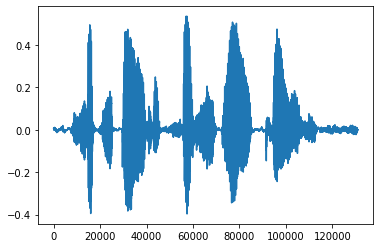

In [96]:
imdct = IMDCT(n_fft=1024, hop_length=512, win_length=1024, window=kbdwin, center=True)
recover1 = imdct(spectro_1.unsqueeze(0).contiguous()).squeeze()
print(recover1.size())
print(recover1.mean())
plt.plot(recover1.cpu().numpy())
plt.show()

1.080573000426959e-17


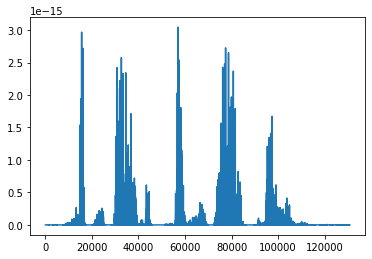

In [97]:
err = torch.pow(recover1[:130816].cpu()-audio_seg.cpu(),2).squeeze().numpy()
print(err.mean())
plt.plot(err)
plt.show()

In [88]:
err_cross = torch.pow(recover1[:130816].cpu()-recover2[:130816].cpu(),2).squeeze().numpy()
print(err_cross.mean())
plt.plot(err_cross)
plt.show()

NameError: name 'recover2' is not defined

In [89]:
mdct2 = MDCT(n_fft=512, hop_length=256, win_length=512, window=torch.kaiser_window, center=False)
audio_low = aF.resample(audio_seg,fs,fs/4)
low_spectro = mdct2(audio_low.cuda().squeeze(0)).permute(1,0)
low_spectro = aF.amplitude_to_DB((low_spectro.abs() + 1e-7),20,1e-7,1).squeeze(0)
sp_fig, sp_ax = plt.subplots()
sp_ax.pcolormesh(low_spectro.cpu().numpy(), cmap='PuBu_r')
plt.show()

torch.Size([127, 512])


AttributeError: 'tuple' object has no attribute 'permute'

In [ ]:
audio_low_high = aF.resample(audio_low,fs/4,fs)
spectro_low_high = mdct1(audio_low_high.cuda().squeeze(0)).permute(1,0)
spectro_low_high = aF.amplitude_to_DB((spectro_low_high.abs() + 1e-7),20,1e-7,1).squeeze(0)
hr = spectro[:256,:]
hr_min = torch.min(hr)
hr_max = torch.max(hr)
hr = (hr-hr_min)/(hr_max-hr_min)
lr = spectro_low_high[:256,:]
lr_min = torch.min(lr)
lr_max = torch.max(lr)
lr = (lr-lr_min)/(lr_max-lr_min)
print(hr.mean())
print(lr.mean())
sp_fig, sp_ax = plt.subplots()
sp_ax.pcolormesh(hr.cpu().numpy(), cmap='PuBu_r')
plt.show()

In [ ]:
diff = (hr-lr).cpu().numpy()
sp_fig, sp_ax = plt.subplots()
sp_ax.pcolormesh(diff, cmap='PuBu_r')
sp_hist_fig, sp_hist_ax = plt.subplots()
sp_hist_ax.hist(diff.reshape(-1,1),bins=100)
plt.show()

In [ ]:
x = torch.Tensor([[[  1,  2,  3,  4,  5,  6],
   					[  7,  8,  9,  10, 11, 12],
   					[  13, 14, 15, 16, 17, 18],
   					[  19, 20, 21, 22, 23, 24]]]).transpose_(-1,-2)
fold = nn.Fold(kernel_size=(1,6), stride=(1,2), output_size=(1,12))
print(x)
print(x.size())
x = fold(x)
print(x)
print(x.size())

In [ ]:
x = torch.Tensor([[[  1,  2,  3,  4,  5,  6],
   					[  7,  8,  9,  10, 11, 12],
   					[  13, 14, 15, 16, 17, 18],
   					[  19, 20, 21, 22, 23, 24]]])
from torch.nn.functional import fold
out_len = (x.size()[-2]-1) * 2 + 6
x = fold(x.transpose_(-1,-2), kernel_size=(1,6), stride=(1,2), output_size=(1,out_len))
print(x)

In [ ]:
from torch.nn.functional import fold
from torch import nn
class IMDCT(nn.Module):
    def __init__(self, n_fft=2048, hop_length=None, win_length=None, window=None, center=True, pad_mode='constant', device='cuda') -> None:
        super().__init__()
        self.n_fft = n_fft
        self.pad_mode = pad_mode
        self.device = device
        self.hop_length = hop_length
        self.center = center

        # making window
        if window is None:
            window = torch.ones
        if callable(window):
            self.win_length = int(win_length)
            self.window = window(self.win_length).to(self.device)
        else:
            self.window = window.to(self.device)
            self.win_length = len(window)

        assert self.win_length <= self.n_fft, 'Window lenth %d should be no more than fft length %d'%(self.win_length, self.n_fft)
        assert self.hop_length <= self.win_length, 'You hopped more than one frame'

        self.idct = IDCT()

    def forward(self, signal):
        assert signal.dim() == 3, 'Only tensors shaped in BHW are supported'
        assert signal.size()[-1] == self.n_fft, 'The last dim of input tensor should match the n_fft. Expected %d ,got %d'%(self.n_fft, signal.size()[-1])

        # Inverse transform at the last dim
        signal = self.idct(signal.to(self.device))

        # Remove padded zeros when doing dct
        if self.n_fft > self.win_length:
            signal = signal[...,:self.win_length]

        # Apply windows to each pieces
        signal = torch.mul(signal, self.window)

        # Overlapping adding by fold()
        out_len = (signal.size()[-2]-1) * self.hop_length + self.win_length
        signal = fold(signal.transpose_(-1,-2), kernel_size=(1,self.win_length), stride=(1,self.hop_length), output_size=(1,out_len))

        if self.center:
            # extract the middle part
            signal = signal[..., self.win_length//2:]

        return signal

In [ ]:
import torchaudio
import matplotlib.pyplot as plt
import torch
import torchaudio.functional as aF
from time import perf_counter
from contextlib import contextmanager
import numpy as np
@contextmanager
def catchtime() -> float:
    start = perf_counter()
    yield lambda: perf_counter() - start

audio_path = '/root/VCTK-Corpus/wav48/p225/p225_003.wav'
audio, fs = torchaudio.load(audio_path)

from models.mdct import MDCT2 as MDCT
mdct1 = MDCT(n_fft=1024, hop_length=100, win_length=1024, window=torch.kaiser_window, center=False, device='cuda')

from models.mdct import MDCT as MDCT_S
mdct2 = MDCT_S(n_fft=1024, step_length=100, window_function=torch.kaiser_window(1024).cuda(), center=False, device='cuda')

time1 = []
time2 = []

for K in range(1000):
    audio_seg = audio[...,K:51176+1024+K].squeeze()
    with catchtime() as t:
        spectro_1 = mdct1(audio_seg.cuda().squeeze(0))
    time1.append(t())

    with catchtime() as t:
        spectro_2 = mdct2(audio_seg.cuda().unsqueeze(0).unsqueeze(0).unsqueeze(0))
    time2.append(t())

print(np.mean(time1))
print(np.mean(time2))

In [ ]:
a = torch.randn(8,256,512,device='cuda')
from models.mdct import IMDCT2
imdct = IMDCT2(window=torch.kaiser_window, win_length=512, hop_length=100, n_fft=512, center=False, device = 'cuda')
print(imdct(a).size())

torch.Size([1024, 1299])


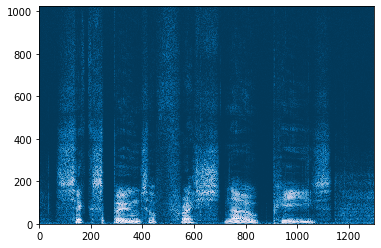

NotImplementedError: You must implement either the backward or vjp method for your custom autograd.Function to use it with backward mode AD.

In [9]:
from models.mdct import MDCT2
from dct.dct2_fft2
mdct = MDCT2(n_fft=1024, hop_length=100, win_length=1024, window=torch.kaiser_window, center=False, device='cuda')
audio_seg.requires_grad_()
spectro = mdct(audio_seg.cuda().squeeze(0))
spectro = aF.amplitude_to_DB((spectro.permute(1,0).abs() + 1e-4),20,1e-4,1).squeeze(0)
print(spectro.size())
plt.pcolormesh(spectro.detach().cpu().numpy(), cmap='PuBu_r')
plt.show()
grad_test = torch.mean(spectro)
grad_test.backward()
print(spectro.grad)

In [ ]:
psudo_pha = 2*torch.randint(low=0,high=2,size=spectro.size())-1
plt.pcolormesh(psudo_pha.cpu().numpy())
plt.show()

In [ ]:
size = spectro.size(-2)
pha = torch.sign(spectro).cpu()
psudo_pha = 2*torch.randint(low=0,high=2,size=pha.size())-1
up_ratio = 6
pha = torch.cat((pha[...,:int(size*(1/up_ratio)),:],psudo_pha[...,int(size*(1/up_ratio)):,:]),dim=-2)
plt.pcolormesh(pha.cpu().numpy())
plt.show()

In [6]:
def kbdwin(N:int, beta=12.0)->torch.Tensor:
    w = torch.kaiser_window(window_length=N//2+1, beta=beta*torch.pi, periodic=False,dtype=torch.double)
    w_sum = w.sum()
    wdw_half = torch.sqrt(torch.cumsum(w,dim=0)/w_sum)[:-1]
    return torch.cat((wdw_half,wdw_half.flip(dims=(0,))),dim=0)

In [ ]:
kbdwin(16,12.0)
#torch.kaiser_window(window_length=8,periodic=False,beta=5)

torch.Size([257, 512])
torch.Size([1, 257, 512])
tensor(4.8908e-32, dtype=torch.float64)


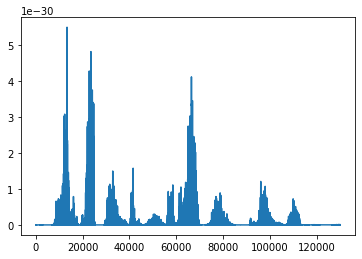

In [4]:
from models.mdct import MDCT4, IMDCT4
mdct4 = MDCT4(n_fft=1024, hop_length=512, win_length=1024, window=kbdwin, center=True, device='cuda')
imdct4 = IMDCT4(n_fft=1024, hop_length=512, win_length=1024, window=kbdwin, center=True, device='cuda')
spectro = mdct4(audio_seg.cuda())
print(spectro.size())
reconstruction = imdct4(spectro.unsqueeze(0))
err = (audio_seg.cpu().squeeze()[:130000] - reconstruction.squeeze().cpu()[:130000])**2
print(err.mean())
plt.plot(err)
plt.show()

In [2]:
from dct.dct_native import DCT_2N_native, IDCT_2N_native
dct = DCT_2N_native()
idct = IDCT_2N_native()
a = torch.Tensor([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]).cuda()
A = dct(a)
aa = idct(A)
print(A)
print(aa)

tensor([ 1.7000e+01, -6.4741e+00,  0.0000e+00, -7.0977e-01,  5.9605e-08,
        -2.4805e-01,  0.0000e+00, -1.2005e-01,  5.9605e-08, -6.6354e-02,
         1.7881e-07, -3.7880e-02, -2.9802e-08, -1.9813e-02, -7.4506e-08,
        -6.1858e-03], device='cuda:0')
tensor([ 2.0000,  4.0000,  6.0000,  8.0000, 10.0000, 12.0000, 14.0000, 16.0000,
        18.0000, 20.0000, 22.0000, 24.0000, 26.0000, 28.0000, 30.0000, 32.0000],
       device='cuda:0')


torch.Size([257, 1024])
tensor(8.5719e-34, dtype=torch.float64)


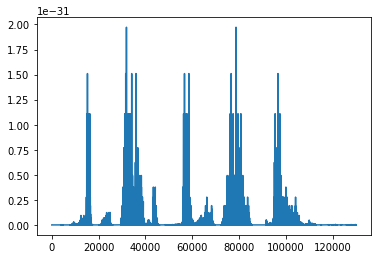

In [7]:
from dct.dct_native import DCT_2N_native, IDCT_2N_native
from models.mdct import MDCT2, IMDCT2
dct = DCT_2N_native()
idct = IDCT_2N_native()
mdct2 = MDCT2(n_fft=1024, hop_length=512, win_length=1024, window=kbdwin, center=True, device='cuda',dct_op=dct)
imdct2 = IMDCT2(n_fft=1024, hop_length=512, win_length=1024, window=kbdwin, center=True, device='cuda',idct_op=idct)
spectro = mdct2(audio_seg.cuda())
print(spectro.size())
reconstruction = imdct2(spectro.unsqueeze(0))
err = (audio_seg.cpu().squeeze()[:130000] - reconstruction.squeeze().cpu()[:130000])**2
print(err.mean())
plt.plot(err)
plt.show()

In [10]:
audio_seg.requires_grad_()
spectro = mdct2(audio_seg.cuda().squeeze(0))
#spectro = aF.amplitude_to_DB((spectro.permute(1,0).abs() + 1e-4),20,1e-4,1).squeeze(0)
reconstruction = imdct2(spectro.unsqueeze(0))
err = (audio_seg.cpu().squeeze()[:130000] - reconstruction.squeeze().cpu()[100:130100])**2
grad_test = torch.mean(err)
grad_test.backward()
print(audio_seg.grad)

tensor([ 6.2913e-08,  8.4980e-08,  8.4510e-08,  ..., -2.0932e-29,
        -6.2280e-29, -1.8424e-29])


In [21]:
from torch import nn
from torch.nn.functional import pad
class MDCT(nn.Module):
    def __init__(self, n_fft=2048, hop_length=None, win_length=None, window=None, center=True, pad_mode='constant', device='cuda') -> None:
        super().__init__()
        self.n_fft = n_fft
        self.pad_mode = pad_mode
        self.device = device
        self.hop_length = hop_length
        self.center = center

        # making window
        if window is None:
            window = torch.ones
        if callable(window):
            self.win_length = int(win_length)
            self.window = window(self.win_length).to(self.device)
        else:
            self.window = window.to(self.device)
            self.win_length = len(window)

        assert self.win_length <= self.n_fft, 'Window lenth %d should be no more than fft length %d'%(self.win_length, self.n_fft)
        assert self.hop_length <= self.win_length, 'You hopped more than one frame'

    def forward(self, signal):
        # Pad the signal to a proper length
        signal_len = int(len(signal))
        start_pad = 0
        # Pad the signal so that the t-th frame is centered at time t * hop_length. Otherwise, the t-th frame begins at time t * hop_length.
        if self.center:
            start_pad = self.hop_length
        additional_len = signal_len%self.hop_length
        end_pad = start_pad
        if additional_len:
            end_pad = start_pad + self.hop_length - additional_len
        signal = pad(signal, (start_pad,end_pad), mode=self.pad_mode)

        # Slice the signal with overlapping
        signal = signal.unfold(dimension=-1, size=self.win_length, step=self.hop_length)

        # Apply windows to each pieces
        signal = torch.mul(signal.to(self.device), self.window.to(self.device))
        return signal

torch.Size([257, 1024])


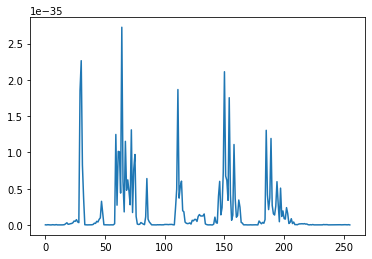

In [22]:
win=kbdwin(1024).cuda()
mdct2 = MDCT(n_fft=1024, hop_length=512, win_length=1024, window=win, center=True, device='cuda')
spectro = mdct2(audio_seg.cuda())
print(spectro.size())
err = ((spectro[:-1,512:]*win[:512]-spectro[1:,:512]*win[512:])**2).mean(-1).cpu().numpy()
plt.plot(err)
#plt.pcolormesh(spectro.cpu().numpy(), cmap='PuBu_r')
plt.show()